In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [12]:
df = df.drop_duplicates(['MIC']).reset_index(drop=True)

In [15]:
df2 = df[df['MIC'] >= 1e-3]

In [16]:
df2

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
414,EELRVRLASHLRKLRKRLLRDADDLQKRLAVYEEQAQQIRLQAEAF...,0.67000
415,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130
416,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
417,CFPYITRPGTYHDWWYTRKNRQ,0.30000


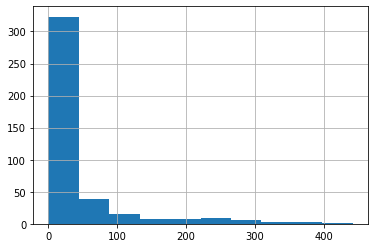

In [17]:
df2['MIC'].hist()

In [18]:
df2['pIC50'] = df2['MIC'].apply(lambda x: -np.log(x*1e-6))

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df2

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
414,EELRVRLASHLRKLRKRLLRDADDLQKRLAVYEEQAQQIRLQAEAF...,0.67000,14.215988
415,SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKEL,0.00130,20.460902
416,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
417,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483


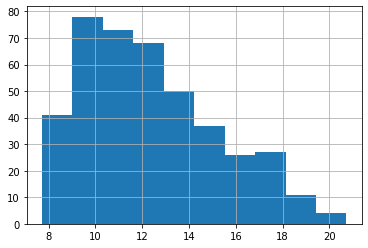

In [20]:
df2['pIC50'].hist()

In [21]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [22]:
dipep_freq = reduce_by_kmer_frequency(df2, kmer=2)

In [23]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 420/420 [00:00<00:00, 1173.81sequence/s]


In [24]:
physicochemical_prop = get_physicochemical_properties(df2)

In [25]:
X = pd.concat([dipep_freq, physicochemical_prop[['turn']]], axis=1)

In [26]:
y = df2[['pIC50', 'MIC']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [30]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [93]:
svr = SVR(C=100, gamma=3)
cv_score = cross_val_score(svr, X_train, y_train_mic, cv=5, scoring=mape_scorer)
cv_mean = cv_score.mean()
print(cv_score, cv_mean)

print(pearsonr(y_test_mic,y_pred))
_ = svr.fit(X_train, y_train_mic)
y_pred = svr.predict(X_test)

print(np.std(y_test_mic), np.std(y_pred))

ape = 100*np.abs(y_test_mic-y_pred)/y_test_mic
ape.mean()

[-5420.44308469 -1582.66598384 -3836.78732979 -1466.57649455
 -5850.16332342] -3631.3272432560652
(0.12850190907445044, 0.24696161496914104)
83.79786073165315 25.905375611695874


26005.04906178785

In [92]:
gg = list(zip(y_test_mic.round(6), y_pred.round(6), ape))

In [68]:
sorted(gg, key=lambda x:x[2])

[(54.587, 53.861203, 1.3296149039824434),
 (34.6, 32.931423, 4.822477722726292),
 (21.5, 20.148995, 6.283745968399277),
 (45.5, 50.317977, 10.588960854644949),
 (11.62, 10.311148, 11.26378727155681),
 (54.4, 45.650889, 16.082924914038635),
 (6.5, 5.420433, 16.608724718668974),
 (4.89, 4.040562, 17.370915155883857),
 (57.981, 44.540906, 23.180169013628213),
 (43.502, 53.616809, 23.251366183142064),
 (5.42, 3.973833, 26.68204314889482),
 (33.0, 45.511288, 37.912994455240494),
 (33.871, 20.058523, 40.77965430877221),
 (42.0, 24.05149, 42.73454677952943),
 (23.46, 13.008986, 44.54822728332989),
 (3.0, 1.634109, 45.529701885510576),
 (12.72, 6.465941, 49.16712710802644),
 (58.1, 25.985071, 55.27526513048448),
 (3.97, 1.751254, 55.887802792326575),
 (156.0, 65.478392, 58.026671986800444),
 (0.93, 0.356099, 61.70978839836486),
 (118.0, 37.707976, 68.04408812918615),
 (196.0, 59.740565, 69.52011966442386),
 (3.1, 0.923355, 70.21436031860593),
 (60.018, 17.492573, 70.85445577675468),
 (50.0, 14

In [69]:
from scipy.stats import pearsonr

### ANN

In [153]:
from keras import backend as K
import matplotlib.pyplot as plt

In [154]:
def PCC(y_true, y_pred):

    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom


    return K.mean(result)

In [94]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [148]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

In [149]:
model.compile(optimizer='adam', loss="mean_absolute_percentage_error", metrics=[PCC])

In [150]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               102912    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

In [151]:
history = model.fit(X_train, y_train_mic, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
9/9 [==============================] - 0s 17ms/step - loss: 103.4422 - PCC: 0.1412 - val_loss: 95.0938 - val_PCC: 0.1230
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 101.6196 - PCC: -0.0793 - val_loss: 91.8304 - val_PCC: -0.2879
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 102.7137 - PCC: 0.1281 - val_loss: 91.0466 - val_PCC: -0.3281
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 98.0495 - PCC: 0.1021 - val_loss: 93.3543 - val_PCC: 0.3071
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 102.0173 - PCC: 0.1297 - val_loss: 92.7261 - val_PCC: -0.1935
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 97.0323 - PCC: 0.1063 - val_loss: 92.1995 - val_PCC: -0.2727
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 94.3003 - PCC: 0.0768 - val_loss: 93.6264 - val_PCC: -0.2534
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 9

9/9 [==============================] - 0s 4ms/step - loss: 77.1207 - PCC: 0.3101 - val_loss: 164.9491 - val_PCC: 0.0158
Epoch 63/100
9/9 [==============================] - 0s 5ms/step - loss: 77.2233 - PCC: 0.3340 - val_loss: 171.7705 - val_PCC: 0.0178
Epoch 64/100
9/9 [==============================] - 0s 5ms/step - loss: 75.7450 - PCC: 0.3100 - val_loss: 193.9626 - val_PCC: 0.0209
Epoch 65/100
9/9 [==============================] - 0s 4ms/step - loss: 78.5489 - PCC: 0.2341 - val_loss: 185.9783 - val_PCC: 0.0208
Epoch 66/100
9/9 [==============================] - 0s 4ms/step - loss: 75.2494 - PCC: 0.3473 - val_loss: 176.4053 - val_PCC: 0.0191
Epoch 67/100
9/9 [==============================] - 0s 4ms/step - loss: 76.4324 - PCC: 0.3841 - val_loss: 187.3381 - val_PCC: 0.0185
Epoch 68/100
9/9 [==============================] - 0s 4ms/step - loss: 74.4725 - PCC: 0.3193 - val_loss: 202.0187 - val_PCC: 0.0176
Epoch 69/100
9/9 [==============================] - 0s 4ms/step - loss: 73.7461 - 

In [152]:
plt.plot(history.history[])

NameError: name 'plt' is not defined

In [144]:
y_pred_mic = model.predict(X_test)
y_pred_mic = y_pred_mic.squeeze()

In [145]:
ape = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [146]:
gg = list(zip(y_test_mic.round(6), y_pred_mic.round(6), ape))

In [147]:
sorted(gg, key=lambda x:x[2])

[(21.5, 21.200806, 1.3916015625),
 (43.502, 41.47345, 4.663119610520771),
 (11.62, 12.444078, 7.091897120779443),
 (0.049, 0.053421, 9.021722966310925),
 (3.97, 4.42161, 11.375575702196398),
 (0.01, 0.008821, 11.786057054996492),
 (54.587, 48.143234, 11.80457938166653),
 (34.6, 29.812653, 13.836264196847907),
 (0.029, 0.033158, 14.337213594337998),
 (0.79, 0.922121, 16.724153108234642),
 (0.82, 0.658435, 19.703021282103002),
 (4.07, 3.113845, 23.492743283583437),
 (19.745, 14.785042, 25.12007187094439),
 (0.899, 0.610527, 32.088251241189624),
 (57.981, 38.979084, 32.772659983628124),
 (0.662, 0.415401, 37.25065198189542),
 (1.965, 1.200694, 38.8959935603251),
 (45.5, 26.447369, 41.873915116865554),
 (1.23, 1.779662, 44.68792977371836),
 (4.89, 2.635358, 46.10719641781048),
 (5.42, 7.93372, 46.37859984957424),
 (4.73, 1.960332, 58.55534303515961),
 (0.045, 0.018575, 58.722997042867874),
 (54.4, 16.087069, 70.42818279827343),
 (12.72, 3.544001, 72.13835986155385),
 (110.0, 29.902012, 72.